This notebook demonstrates the use of the scPDA package. The primary function of the scPDA package is to perform protein count denoising at the single-cell level. In practice, single-cell datasets rarely consist solely of protein data. Instead, they are typically multi-omics datasets, such as CITE-seq, which integrate protein data with other modalities. `Seurat`, an R-based tool, shows the best compatibility in this context. Therefore, in this notebook, we primarily conducted analyses using R.

**Required Python packages:**
scPDA, torch, numpy, pandas, rpy2

Install via pip:
`pip install scPDA torch numpy pandas rpy2`


**Required R packages:**
mclust, dplyr, Seurat, ggplot2

Install in R using:
`install.packages(c('mclust', 'dplyr', 'Seurat', 'ggplot2'))`


In [1]:
from scPDA import Denoiser
import torch
import numpy as np
import random
import pandas as pd
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
%load_ext rpy2.ipython

In [2]:
%%R
suppressMessages(require(mclust))
suppressMessages(require(dplyr))
suppressMessages(require(Seurat))
suppressMessages(require(ggplot2))


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

### 1. Reading in the raw counts and metadata


In [3]:
%%R
raw_counts <- read.csv("raw_counts.csv", row.names = 1)
meta_data = read.csv('meta_data.csv', row.names = 1)

### 2. Estimating the background noise
scPDA requires the estimation of background noise ($\mu_1$). Here we utilize the `mclust` package to estimate it from the raw count matrix $(X)$. This is achieved by comparing models with 2 to 3 components and selecting the one with the lowest Bayesian Information Criterion (BIC) score. If your dataset includes empty droplets identified with high confidence, we recommend using their average protein counts as the background noise estimate. (The latest version of scPDA includes a built-in function to estimate the background noise.)

In [4]:
%%R
set.seed(1)
bg_noise_list = apply(raw_counts, 1, function(x) {Mclust(x, G = 2:3, warn = FALSE, verbose = FALSE)})
mu1 = sapply(bg_noise_list, function(x) sort(x$parameters$mean)[1] %>% unname) %>% as.data.frame()

### 3. Training the scPDA model

The denoised counts are obtained after training and stored in `scPDA.denoised_counts`. This is achieved by 
$(1 - \pi_{ij}) \times X$, where $\pi_{ij}$ is the estimated probability of raw count $X_{ij}$ being background noise. $\pi$ is stored in `scPDA.pi`.


In [5]:
# Assign the raw counts (cell-by-protein) and background noise to Python
raw_counts = %R raw_counts
mu1 = %R mu1
raw_counts_tensor = torch.tensor(np.array(raw_counts).transpose())
mu1_tensor = torch.tensor(mu1.to_numpy().squeeze())

# Train the model
model = Denoiser(raw_counts=raw_counts_tensor,  # raw counts (cell-by-protein)
                 bg_mean=mu1_tensor)  # background noise
model.train()
model.inference()

# Save the denoised counts to a dataframe
denoised_cts = pd.DataFrame(model.denoised_counts).transpose()
denoised_cts.index = raw_counts.index
denoised_cts.columns = raw_counts.columns

Training: 100%|██████████| 500/500 [00:18<00:00, 26.96epoch/s]


### 4. Analysis

In [6]:
%%R -i denoised_cts
# Create Seurat objects for raw and denoised counts
raw = CreateSeuratObject(counts = raw_counts, meta.data = meta_data, assay = 'Protein') %>% 
  NormalizeData(normalization.method = 'CLR', margin=2)
Idents(raw) = 'type'
denoised = SetAssayData(raw, slot='counts', new.data=as.matrix(denoised_cts)) %>% 
  NormalizeData(normalization.method = 'CLR', margin=2)

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 2 % ~00s           |++                                                | 3 % ~00s           |+++                                               | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 7 % ~00s           |+++++                                             | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 12% ~00s           |+++++++                                           | 13% ~00s 

Normalizing across cells
Normalizing across cells


In [7]:
%%R
lfc <- function(obj, prot, pos, neg) {
    pos_mean = mean(obj[["Protein"]]@counts[prot, obj$type %in% pos])
    neg_mean = mean(obj[["Protein"]]@counts[prot, obj$type %in% neg])
    return(log2(pos_mean/neg_mean))
}

ridge.plot <- function(prot, pos, neg) {
  lfc.raw = lfc(raw, prot, pos, neg)
  lfc.denoised = lfc(denoised, prot, pos, neg)
  print(sprintf("The log fold change by raw counts is %.2f", lfc.raw))
  print(sprintf("The log fold change by denoised counts is %.2f", lfc.denoised))
  raw.ridge <- RidgePlot(raw %>% subset(type!='remaining'), features=prot, slot='data') + 
    NoLegend() + theme(axis.title.y = element_blank()) + ggtitle(paste0(prot, 'Raw Counts')) + labs(x='CLR Value')
  denoised.ridge <- RidgePlot(denoised %>% subset(type!='remaining'), features=prot, slot='data') + 
    NoLegend() + theme(axis.title.y = element_blank()) + ggtitle(paste0(prot, 'Denoised Counts')) + labs(x='CLR Value')
  return(raw.ridge + denoised.ridge)
}

The log fold change (LFC) compares the average expression of a protein in its corresponding positive against negative cell types, which is imporved after denoising.

[1] "The log fold change by raw counts is 7.09"
[1] "The log fold change by denoised counts is 15.08"


Picking joint bandwidth of 0.0702
Picking joint bandwidth of 0.042


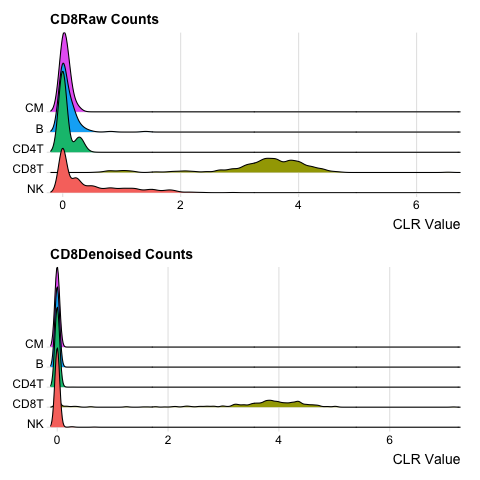

In [8]:
%%R
prot='CD8'; pos = c('CD8T'); neg = c('B', 'CM', 'CD4T', 'NK')
plot(ridge.plot(prot, pos, neg))

[1] "The log fold change by raw counts is 7.81"
[1] "The log fold change by denoised counts is 14.05"


Picking joint bandwidth of 0.0488
Picking joint bandwidth of 0.0369


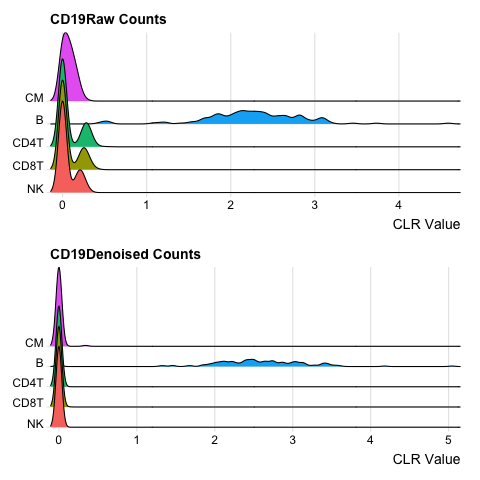

In [9]:
%%R
prot='CD19'; pos = c('B'); neg = c('CD8T', 'CM', 'CD4T', 'NK')
plot(ridge.plot(prot, pos, neg))

In [10]:
%load_ext watermark
%watermark -v -p numpy,pandas,torch,rpy2,scPDA

Python implementation: CPython
Python version       : 3.10.0
IPython version      : 8.25.0

numpy : 1.26.4
pandas: 2.2.3
torch : 2.5.1
rpy2  : 3.5.17
scPDA : 0.5.0



In [11]:
%%R
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: aarch64-apple-darwin20 (64-bit)
Running under: macOS Sonoma 14.5

Matrix products: default
BLAS:   /System/Library/Frameworks/Accelerate.framework/Versions/A/Frameworks/vecLib.framework/Versions/A/libBLAS.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.11.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/Denver
tzcode source: internal

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] ggplot2_3.4.4      SeuratObject_4.1.3 Seurat_4.3.0       dplyr_1.1.4       
[5] mclust_6.1.1      

loaded via a namespace (and not attached):
  [1] deldir_2.0-4           pbapply_1.7-2          gridExtra_2.3         
  [4] rlang_1.1.4            magrittr_2.0.3         RcppAnnoy_0.0.22      
  [7] matrixStats_1.4.1      ggridges_0.5.6         compiler_4.3.2       